# Sviluppo e training di RNN per analisi di sequenze temporali

### Informazioni ###

scopo: 
- apprendere uso e funzionalità delle RNN rispetto a una task tipica per queste architetture: predizioni di feature sulla base di esempi di serie temporali

**Dataset:**

dataset kaggle con andamento titolo di borsa Tata Global Beverages Ltd borsa Indiana

In [160]:
import tensorflow as tf 
print(tf.__version__)

from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import os
import time

import pandas as pd

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

if len(tf.config.list_physical_devices('GPU')) == 0:
    print('Per questa esercitazione è importante usare la GPU: cambia runtime: menu Runtime > Change Runtime Type > GPU)')

2.2.0


# Parte 1: predizione andamento titolo di borsa

In [161]:
# Dataset 
!rm -rf NSE-TATAGLOBAL.csv
!rm -rf NSE-TATAGLOBAL-test.csv
!wget http://giagu.web.cern.ch/giagu/CERN/NSE-TATAGLOBAL.csv
!wget http://giagu.web.cern.ch/giagu/CERN/NSE-TATAGLOBAL-test.csv
!ls 

--2020-05-21 16:23:04--  http://giagu.web.cern.ch/giagu/CERN/NSE-TATAGLOBAL.csv
Resolving giagu.web.cern.ch (giagu.web.cern.ch)... 188.184.101.49, 2001:1458:d00:35::100:35
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.184.101.49|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 115525 (113K) [text/csv]
Saving to: ‘NSE-TATAGLOBAL.csv’

NSE-TATAGLOBAL.csv  100%[===================>] 112.82K  --.-KB/s    in 0.1s    

2020-05-21 16:23:04 (1.11 MB/s) - ‘NSE-TATAGLOBAL.csv’ saved [115525/115525]

--2020-05-21 16:23:08--  http://giagu.web.cern.ch/giagu/CERN/NSE-TATAGLOBAL-test.csv
Resolving giagu.web.cern.ch (giagu.web.cern.ch)... 188.184.101.49, 2001:1458:d00:35::100:35
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.184.101.49|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 984 [text/csv]
Saving to: ‘NSE-TATAGLOBAL-test.csv’

NSE-TATAGLOBAL-test 100%[===================>]     984  --.-KB/s    in 0s      

2020-05-21 16:23:08 

In [0]:
# Usiamo pandas per leggere il dataset in formato csv

# training data
df = pd.read_csv('NSE-TATAGLOBAL.csv')
# test data
df_test = pd.read_csv('NSE-TATAGLOBAL-test.csv')

In [163]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035 entries, 0 to 2034
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  2035 non-null   object 
 1   Open                  2035 non-null   float64
 2   High                  2035 non-null   float64
 3   Low                   2035 non-null   float64
 4   Last                  2035 non-null   float64
 5   Close                 2035 non-null   float64
 6   Total Trade Quantity  2035 non-null   int64  
 7   Turnover (Lacs)       2035 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 127.3+ KB


In [164]:
df.head(5)

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [165]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Last', 'Close', 'Total Trade Quantity',
       'Turnover (Lacs)'],
      dtype='object')

In [0]:
# ordiniamo i valori in tempo crescente
df.sort_values('Date', inplace=True, ascending=True, ignore_index=True)
df_test.sort_values('Date', inplace=True, ascending=True, ignore_index=True)

In [167]:
print('Inizio della sequenza temporale: ', df.Date.min())
print('Fine della sequenza temporale: ', df.Date.max())

Inizio della sequenza temporale:  2010-07-21
Fine della sequenza temporale:  2018-09-28


In [168]:
print('Inizio della sequenza temporale (test set): ', df_test.Date.min())
print('Fine della sequenza temporale (test set): ', df_test.Date.max())

Inizio della sequenza temporale (test set):  2018-10-01
Fine della sequenza temporale (test set):  2018-10-24


In [169]:
df.head(5)

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56
1,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
3,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
4,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98


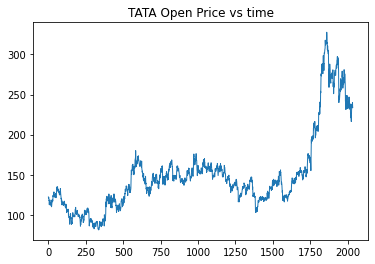

In [170]:
#Data Exploration

# grafichiamo la il prezzo di apertura in funzione della data

plt.plot(df['Open'],linewidth=1)
plt.title('TATA Open Price vs time')
plt.show()


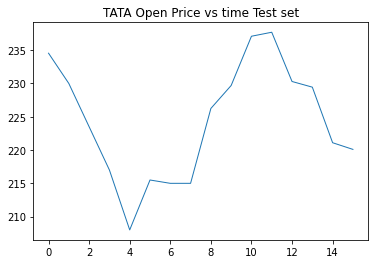

In [171]:
plt.plot(df_test['Open'],linewidth=1)
plt.title('TATA Open Price vs time Test set')
plt.show()


## Costruzione del modello RNN (una LSTM multilayer)

*   task: predire il vaore del titolo (feature *Open*) al tempo corrente a partire dalla storia del titolo a tempi precedenti 

Step necessari:

*   normalizzare le feature
*   split in training/validation
*   adeguare la shape dei dati per l'input atteso per una RNN in TF/keras: 3D array *(num_samples, num_timesteps, num_features)*
*   costruzione del modello in keras


In [0]:
# selezioniamo solo la feature interessante (Open price) e convertiamo i dati 
# in array numpy
training_set = df.iloc[:, 1:2].values
# normalizziamo le feature in [0,1]
scaler = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = scaler.fit_transform(training_set)

In [271]:
# Creiamo la strutura di dati adeguata per la RNN: 
# consideriamo timesteps campionamenti in cui osserviamo i valori del titolo a tempi
# precedenti, t-timetamp-delay ... t-delay
# e 1 output corrispondente al valore del titolo al tempo corrente  
# NOTA: nella RNN  input X timestamp valori a tempi precedenti e target X al tempo t
X_train = []
y_train = []

timesteps = 30 #numero di step temporali sequenziali usati per la predizione
delay = 0 #distanza in step temporali tra il target e l'elemento piu' vicino della sequenza temporale

for i in range(timesteps+delay, training_set.shape[0]):
    X_train.append(training_set_scaled[i-timesteps-delay:i-delay, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape)
print(y_train.shape)

(2005, 30)
(2005,)


In [272]:
# Reshaping nel formato atteso da una RNN in TF/keras: 3D array (num_samples, num_timesteps, num_features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)

(2005, 30, 1)


Architettura del modello di RNN:

1.   LSTM con 2 blocchi LSTM sequenziali (stacked LSTM) 
2.   spazio latente *ht* di dimensione 50
3.   dropout 20% per regolarizzare il modello
4.   un nuerone nell'output layer per predire la feature *Open*
5.   loss: MSE,  ottimizzatore: Adam
6.   100 epoche con EarlyStopping, con batch size 32


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 30, 50)            10400     
_________________________________________________________________
dropout_37 (Dropout)         (None, 30, 50)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_38 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


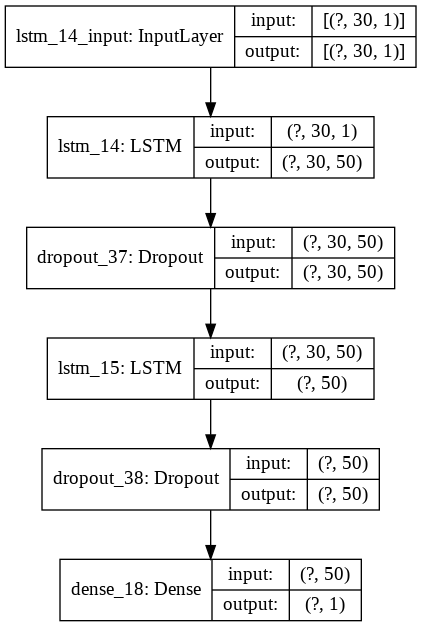

In [273]:
# Stacked LSTM layers con dropouts
model = keras.Sequential()

# return_sequences = True va usato quando l'output della LSTM serve come input 
# ad un'altra LSTM
model.add(layers.LSTM(50, return_sequences = True, input_shape=(X_train.shape[1], 1)))
model.add(layers.Dropout(0.2))

# nell'ultimo modulo LSTM non serve return_sequences = True
model.add(layers.LSTM(50))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(1))

model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [274]:
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(
    X_train, y_train, epochs=100, batch_size=32, 
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='loss', patience=5),
    ]
)

Epoch 1/100
63/63 [==============================] - 1s 15ms/step - loss: 0.0103
Epoch 2/100
63/63 [==============================] - 1s 15ms/step - loss: 0.0024
Epoch 3/100
63/63 [==============================] - 1s 15ms/step - loss: 0.0022
Epoch 4/100
63/63 [==============================] - 1s 15ms/step - loss: 0.0019
Epoch 5/100
63/63 [==============================] - 1s 15ms/step - loss: 0.0018
Epoch 6/100
63/63 [==============================] - 1s 15ms/step - loss: 0.0015
Epoch 7/100
63/63 [==============================] - 1s 15ms/step - loss: 0.0016
Epoch 8/100
63/63 [==============================] - 1s 15ms/step - loss: 0.0015
Epoch 9/100
63/63 [==============================] - 1s 15ms/step - loss: 0.0014
Epoch 10/100
63/63 [==============================] - 1s 15ms/step - loss: 0.0018
Epoch 11/100
63/63 [==============================] - 1s 15ms/step - loss: 0.0014
Epoch 12/100
63/63 [==============================] - 1s 15ms/step - loss: 0.0013
Epoch 13/100
63/63 [=====

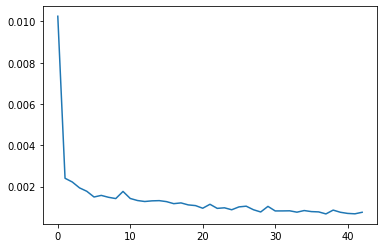

In [275]:
plt.plot(history.history["loss"])

In [0]:
# Calcoliamo la predizione del modello su i dati del test set (set degli stessi dati nel periodo subito 
# successivo)

test_set = df_test.iloc[:, 1:2].values

#concateniamo il dataset di training (che contiene le sequenze precedenti a quelle 
#del test set) con il test set
df_total = pd.concat((df['Open'], df_test['Open']), axis = 0)
inputs = df_total[(len(df_total) - len(df_test) - timesteps - delay):].values
inputs = inputs.reshape(-1,1) #nota -1 significa che numpy ricava la dimensione dalla lunghezza dell'array
inputs = scaler.transform(inputs) #normalizzazione

X_test = []
for i in range(timesteps+delay, timesteps+delay+test_set.shape[0]):
    start = i-(timesteps+delay)
    end = i-delay
    X_test.append(inputs[start:end, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# predizione sul test set
predicted_values = model.predict(X_test)

# riconvertiamo indietro da [0,1] ai valori originali dell'prezzo di borsa
predicted_values = scaler.inverse_transform(predicted_values)

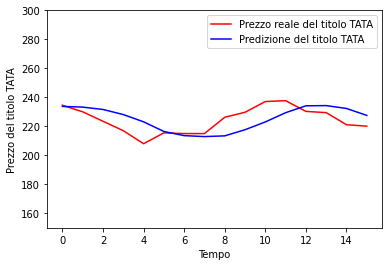

In [277]:
# Grafichiamo il risultato: predizione VS valore vero

plt.plot(test_set, color = 'red', label = 'Prezzo reale del titolo TATA')
plt.plot(predicted_values, color = 'blue', label = 'Predizione del titolo TATA')
plt.ylim(150, 300)
plt.xlabel('Tempo')
plt.ylabel('Prezzo del titolo TATA')
plt.legend()
plt.show()

In [0]:
lstm_model = model

# **Compiti:** 

1.   provare a vedere come cambiano le prestazioni riducendo la complessita della rete (dimensione spazio latente, numero di stack LSTM), e/o passando a RNN di tipo SimpleRNN e GRU
2.   pensare ad un modello naive basato sull'intuizione (vostra) del processo (esempio: la predizione a t potrebbe essere la media dei valori in n t precedenti tra i dati disponibili (dato il valore del delay), oppure il valore più vicino, ...) per stimare il valore del titolo al tempo corrente, misurarne le prestazioni sul test_set e confrontarlo con quanto ottenuto con la RNN ... commenti?
3.   provate a vedere come la qualità della predizione dipende dal numeo di eventi temporali (timestamps) utilizzati e sopratutto dalla distanza temporale (delay) tra l'ultima misura disponibile e il valore corrente. Come infuiscono sulle prestazioni?
4.   provate a costruire un campione di test ottenuto dalle predizioni sul campione di test stesso e iterare la procedura, cosa succede alla predizione?
5.   le prestazioni del modello migliorrebbero aggiungendo ulteriori feature nell'analisi temporale (per esempio: 'Total Trade Quantity' e 'Turnover (Lacs)')? Provare a capire come poter modificare il modello inserendo tali quantità e addestrando un nuovo modello ... (più complesso e opzionale)

# Riduzione della complessità della rete

Utilizzo una rete con Simple RNN (poiché ho solo 2 layer probabilmente non si avrà diluizione del gradiente) e riduco la dimensione dello spazio latente da 50 a 20. Per bilanciare la minore complessità della rete diminuisco il dropout a 0.1.

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_8 (SimpleRNN)     (None, 30, 20)            440       
_________________________________________________________________
dropout_17 (Dropout)         (None, 30, 20)            0         
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dropout_18 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 21        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
63/63 [==============================] - 4s 62ms/step - loss: 0.0803
Epoch 2/100
63/63 [==================

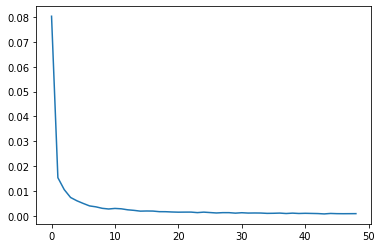

In [183]:
model = keras.Sequential()
model.add(layers.SimpleRNN(20, return_sequences = True, input_shape=(X_train.shape[1], 1)))
model.add(layers.Dropout(0.1))

model.add(layers.SimpleRNN(20))
model.add(layers.Dropout(0.1))

model.add(layers.Dense(1))

model.summary()

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=5)])

plt.plot(history.history["loss"])

# Calcoliamo la predizione del modello su i dati del test set (set degli stessi dati nel periodo subito 
# successivo)

test_set = df_test.iloc[:, 1:2].values

#concateniamo il dataset di training (che contiene le sequenze precedenti a quelle 
#del test set) con il test set
df_total = pd.concat((df['Open'], df_test['Open']), axis = 0)
inputs = df_total[(len(df_total) - len(df_test) - timesteps - delay):].values
inputs = inputs.reshape(-1,1) #nota -1 significa che numpy ricava la dimensione dalla lunghezza dell'array
inputs = scaler.transform(inputs) #normalizzazione

X_test = []
for i in range(timesteps+delay, timesteps+delay+test_set.shape[0]):
    start = i-(timesteps+delay)
    end = i-delay
    X_test.append(inputs[start:end, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

Con 1200 parametri a fronte dei 30000 usati prima si ha una loss finale simile ed una predizione ottima.

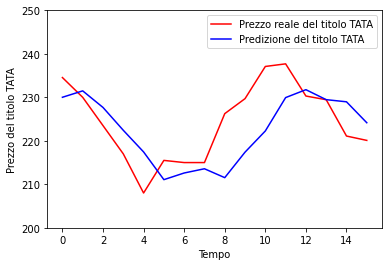

MSE: 57.19767960814757


In [252]:
# predizione sul test set
predicted_values = model.predict(X_test)

# riconvertiamo indietro da [0,1] ai valori originali dell'prezzo di borsa
predicted_values = scaler.inverse_transform(predicted_values)

# Grafichiamo il risultato: predizione VS valore vero

plt.plot(test_set, color = 'red', label = 'Prezzo reale del titolo TATA')
plt.plot(predicted_values, color = 'blue', label = 'Predizione del titolo TATA')
plt.ylim(200, 250)
plt.xlabel('Tempo')
plt.ylabel('Prezzo del titolo TATA')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error

print(f"MSE: {mean_squared_error(predicted_values, test_set)}")

# Confronto con *naive model*

Utilizzo come *naive model* una spline di grado 5, che fitta gli ultimi 100 punti del training set. A questi, per evitare l'esplosione della spline nella previsione, viene aggiunto un pezzo di lunghezza pari al test set e avente sempre un valore pari all'ultimo elemento del training set. 

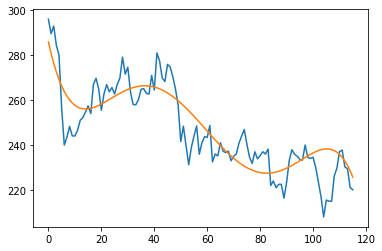

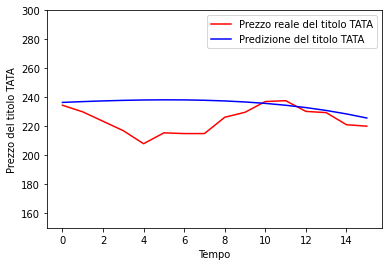

MSE: 216.88329019428016
MSE: 216.88329019428016


In [254]:
from scipy.interpolate import UnivariateSpline
L = 100
x_train = training_set[-L:].reshape(-1)
x_test = test_set.reshape(-1)

_x_train = np.concatenate((x_train, x_train[-1]*np.ones((len(test_set), ))))
x_test = test_set.reshape(-1)
spl = UnivariateSpline(range(len(_x_train)), _x_train, k=5)
plt.plot(np.concatenate((x_train, x_test)))
x = np.asarray(range(L+len(test_set)))
spl.set_smoothing_factor(np.infty)
plt.plot(x, spl(x))
plt.show()
x = range(L, L+len(test_set))
plt.plot(x_test, color = 'red', label = 'Prezzo reale del titolo TATA')
plt.plot(spl(x), color = 'blue', label = 'Predizione del titolo TATA')
plt.ylim(150, 300)
plt.xlabel('Tempo')
plt.ylabel('Prezzo del titolo TATA')
plt.legend()
plt.show()
print(f"MSE: {mean_squared_error(spl(x), x_test)}")

Come si vede, la previsione è abbastanza ragionevole, seppur molto più *smooth* di quella della rete neurale. L'MSE è circa 
4 volte più grande di quello della rete.

# Modifica delay

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_22 (SimpleRNN)    (None, 30, 20)            440       
_________________________________________________________________
dropout_31 (Dropout)         (None, 30, 20)            0         
_________________________________________________________________
simple_rnn_23 (SimpleRNN)    (None, 20)                820       
_________________________________________________________________
dropout_32 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 21        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
63/63 [==============================] - 4s 63ms/step - loss: 0.0415
Epoch 2/100
63/63 [=================

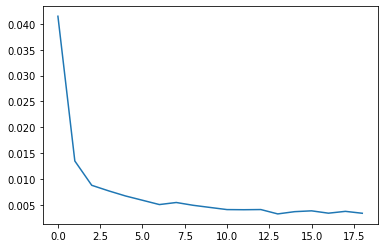

In [257]:
def get_timed_data(input_set, timesteps=30, delay=0):
  X_train = []
  y_train = []

  for i in range(timesteps+delay, input_set.shape[0]):
      X_train.append(training_set_scaled[i-timesteps-delay:i-delay, 0])
      y_train.append(training_set_scaled[i, 0])

  return (np.array(X_train), np.array(y_train))


X_train, y_train = get_timed_data(training_set, delay=10)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

model = keras.Sequential()

model.add(layers.SimpleRNN(20, return_sequences = True, input_shape=(X_train.shape[1], 1)))
model.add(layers.Dropout(0.1))

model.add(layers.SimpleRNN(20))
model.add(layers.Dropout(0.1))

model.add(layers.Dense(1))

model.summary()

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=5)])

plt.plot(history.history["loss"])

# Calcoliamo la predizione del modello su i dati del test set (set degli stessi dati nel periodo subito 
# successivo)

test_set = df_test.iloc[:, 1:2].values

#concateniamo il dataset di training (che contiene le sequenze precedenti a quelle 
#del test set) con il test set
df_total = pd.concat((df['Open'], df_test['Open']), axis = 0)
inputs = df_total[(len(df_total) - len(df_test) - timesteps - delay):].values
inputs = inputs.reshape(-1,1) #nota -1 significa che numpy ricava la dimensione dalla lunghezza dell'array
inputs = scaler.transform(inputs) #normalizzazione

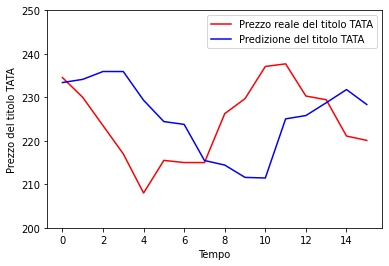

MSE: 164.48057219330627


In [258]:
delay=10
X_test = []
for i in range(timesteps+delay, timesteps+delay+test_set.shape[0]):
    start = i-(timesteps+delay)
    end = i-delay
    X_test.append(inputs[start:end, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# predizione sul test set
predicted_values = model.predict(X_test)

# riconvertiamo indietro da [0,1] ai valori originali dell'prezzo di borsa
predicted_values = scaler.inverse_transform(predicted_values)

# Grafichiamo il risultato: predizione VS valore vero

plt.plot(test_set, color = 'red', label = 'Prezzo reale del titolo TATA')
plt.plot(predicted_values, color = 'blue', label = 'Predizione del titolo TATA')
plt.ylim(200, 250)
plt.xlabel('Tempo')
plt.ylabel('Prezzo del titolo TATA')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error

print(f"MSE: {mean_squared_error(predicted_values, test_set)}")

Aumentando il delay a 10 le prestazioni calano sensibilmente.

# Reiterazione della previsione

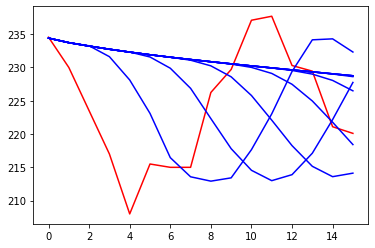

In [301]:
delay = 1

iterations = 10
pred = inputs
plt.plot(test_set, color = 'red', label = 'Prezzo reale del titolo TATA')
df_test["pred"] = df_test['Open']
for i in range(iterations):
  delay = 1
  
  df_total = pd.concat((df['Open'], df_test['pred']), axis = 0)
  inputs = df_total[(len(df_total) - len(df_test) - timesteps - delay):].values
  inputs = inputs.reshape(-1,1) #nota -1 significa che numpy ricava la dimensione dalla lunghezza dell'array
  inputs = scaler.transform(inputs) #normalizzazione

  X_test = []
  for j in range(timesteps+delay, timesteps+delay+test_set.shape[0]):
      start = j-(timesteps+delay)
      end = j-delay
      X_test.append(inputs[start:end, 0])

  X_test = np.array(X_test)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

  df_test["pred"] = scaler.inverse_transform(lstm_model.predict(X_test))
  plt.plot(df_test["pred"], color = 'blue', label = str(i))


La previsione viene sempre di più ritardata, amplificando l'effetto che si ottiene per una singola previsione.